In [1]:
# Core functionality for managing and accessing data
from neurosynth import Dataset, decode, network
import nibabel as nib
import numpy as np
import pandas as pd
import nibabel as nib
#import h5py
#import glob

mode = 0
parc = 'Sch240'

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## CCA data

In [2]:
# load mode weights
cca_mat = np.loadtxt('cca_weights_mat_mode'+str(mode)+'.csv',delimiter=',')

# cca node strength
# I've chosen strength rather than degree as this will account for the number of connections a give node might have
cca_node_strength_signed = np.mean(cca_mat+cca_mat.T,axis=1)

# load the roi-parcellation
if parc=='Sch214':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HO.nii'
elif parc=='BN':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/BNAtlas/BN_Atlas_246_2mm.nii'
elif parc=='Sch240':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HOAAL.nii'
    n_nodes = 240
img_parc = nib.load(parcellation_file)
img_parc_data = img_parc.get_data()

# list of regions
roi_list = range(n_nodes)

## Load the neurosynth dataset and features
Using terms / topics from:  
See see https://github.com/gpreti/GSP_StructuralDecouplingIndex/blob/master/Code_NCOMMS/Python/05_metaanalysis_neurosynth_myanalysis.ipynb

In [3]:
path = '/Users/luke/Documents/Projects/StrokeNet/Data/neurosynth/'

try:
    # Import neurosynth database:
    pickled_dataset=path+'database_feb_2015/dataset.pkl' 
    dataset=Dataset.load(pickled_dataset)
except:

    # Create a new Dataset instance
    dataset = Dataset(path+'database_feb_2015/database.txt')

    # Add some features
    dataset.add_features(path+'database_feb_2015/features.txt')
    dataset.save(path+'database_feb_2015/dataset.pkl')
    
# Analysis with 24 terms:
'''
Several terms were removed due to being considered noise: 
# removed_as_noise = [0,5,9,12,17,40] # from 30 terms that were above threshold
# labels_noise = ['resting-state', 'dementia', 'development', 'misc', 'task timing', 'lateralization']

'''
features = pd.read_csv(path+'database_feb_2015/v3-topics-50.txt', sep='\t', index_col=0)
topics_to_keep = [ 1, 4,  6, 14, 
                  18, 19, 23, 25, 
                  20, 21, 27, 29,
                  30, 31, 33, 35, 
                  36, 38, 37, 41, 
                  44, 45, 48, 49]

labels = ['face/affective processing', ' verbal semantics', 'cued attention', 'working memory', 
          'autobiographical memory', 'reading', 'inhibition', 'motor', 
          'visual perception', 'numerical cognition', 'reward-based decision making', 'visual attention', 
          'multisensory processing', 'visuospatial','eye movements', 'action',
          'auditory processing', 'pain', 'language', 'declarative memory', 
          'visual semantics', 'emotion', 'cognitive control', 'social cognition']

features = features.iloc[:, topics_to_keep]
features.columns = labels
dataset.add_features(features, append=False)

/anaconda3/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()
/anaconda3/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/anaconda3/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()


In [4]:
print_studies = 0
if print_studies:
    num_studies = pd.read_excel(path+'database_feb_2015/database.xlsx',header=0)
    print(len(np.unique(num_studies['id'].values)),'unique studies included')

## Save rois as Nifti
Only needs to be done once

In [5]:
# for roi in roi_list:
#     roi_img = np.zeros((np.shape(img_parc_data)))
#     roi_img[img_parc_data==roi]=1
#     roi_img = nib.Nifti1Image(roi_img,img_parc.affine)
#     out_name = path_to_neurosynthdata+'roi/'+parc+'_roi_'+str(roi)+'.nii'
#     nib.save(roi_img,out_name)

## Decode the rois

from: https://groups.google.com/forum/#!searchin/neurosynthlist/method$3D$27roi$27|sort:date/neurosynthlist/7kyLBuTXUGQ/_Xrt3pF3BQAJ

*You can select that one by passing method='roi', but be aware that it won't produce meaningful results unless you have a binary mask. Basically, it does a meta-analytic comparison of all studies that activate within the passed ROI versus all the ones that don't. If your input _is_ binary, I would probably recommend using this approach rather than the pearson approach. Otherwise stick with pearson (unless you want to implement new methods, which I would certainly welcome).*

In [6]:
## roi method
# set up the decoder
decoder = decode.Decoder(dataset,method='roi')

nii_list=[]
for nii in range(n_nodes):
    roi = roi_list[nii]
    nii = parc+'_roi_'+str(roi)
    nii_list.append(path+'roi/'+nii+'.nii')
    
#run the decoding
neurosynth_results = decoder.decode(nii_list, save=path+'decoding_results_'+parc+'_mode'+str(mode)+'.txt')
neurosynth_results.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_230,cluster_231,cluster_232,cluster_233,cluster_234,cluster_235,cluster_236,cluster_237,cluster_238,cluster_239
face/affective processing,-0.6177,8.4805,7.0210,-0.1928,4.8314,5.5816,-0.2488,1.9426,0.3330,-1.6974,...,-1.4454,-0.8824,-0.8934,-1.0708,-0.9428,-2.8173,-3.0340,-2.0031,-2.1378,-2.6819
verbal semantics,-2.5469,-0.9568,2.4431,-0.0146,0.6768,-0.4744,-1.9304,-1.0891,-1.1203,0.2507,...,-1.9881,-1.1573,-1.3573,-0.5117,-1.6187,-2.3776,-3.0614,-2.6510,-2.0098,-1.3713
cued attention,1.5476,2.2011,0.9397,2.3749,2.2212,1.2286,1.6643,0.2188,0.3036,0.8063,...,-0.7198,-1.6871,-1.1775,-0.8090,0.2189,-0.6243,0.0628,0.2431,-0.5988,-0.8489
working memory,2.8218,0.7041,1.6502,1.3582,1.3481,2.9350,4.8090,0.6908,1.9955,0.2167,...,2.0620,0.4775,0.2896,1.4800,2.3837,2.6662,4.1726,5.9745,1.7774,1.2672
autobiographical memory,5.2806,0.1550,1.4526,0.9493,1.1618,3.0089,1.2752,4.5465,1.3848,5.1418,...,7.8492,3.7377,-0.4604,3.2636,4.3204,2.8110,1.3089,0.5463,0.6740,5.8590


#### trim the results to useful features

In [7]:
# idx = neurosynth_results.index.isin(cognitive_features)

# neurosynth_results_trimmed = neurosynth_results[idx]
# neurosynth_results.to_csv(path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'_trimmed.txt')
# print('number of trimmed features = ',np.shape(neurosynth_results_trimmed))
# neurosynth_results_trimmed.head()

#### normalize (zscore) and weight the features according to the CCA degree


In [8]:
#normalize
from scipy.stats import zscore
#df = neurosynth_results_trimmed
df = neurosynth_results
#for col in list(df.columns):
#    df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
degree = zscore(cca_node_strength_signed)

# threshold
df[df< 0] = 0

#multiply
df = df * degree
df = df.sum(axis=1)
print(df)

face/affective processing        49.161849
 verbal semantics              -183.927650
cued attention                   10.757808
working memory                  -29.782933
autobiographical memory         -80.854939
reading                         -11.872314
inhibition                       99.674493
motor                           -68.171083
visual perception                11.371853
numerical cognition               9.896135
reward-based decision making     75.456888
visual attention                 62.178369
multisensory processing         -29.185629
visuospatial                      9.956421
eye movements                    27.144322
action                          -73.790053
auditory processing             -52.711899
pain                             81.444692
language                       -265.778566
declarative memory             -167.289551
visual semantics                -35.397329
emotion                           3.877968
cognitive control                 8.671474
social cogn

## Visualise the results

In [9]:
def word_brain_plot(df,nii):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from wordcloud import WordCloud

    def getWordFreq(df,nii):
        text = df.index.values
        freq = df[nii].values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df,nii))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()
    
    # brain
    plotting.plot_stat_map(nii,threshold=0.1, title=nii)
    plotting.show()

def word_brain_plot_roi(df,fname):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    def getWordFreq(df):
        text = df.index.values
        freq = df.values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()

In [10]:
values = df.values
labels = df.index.values

idx = np.argsort(values)[::-1]
values_sort = values[idx]
labels_sort = labels[idx]


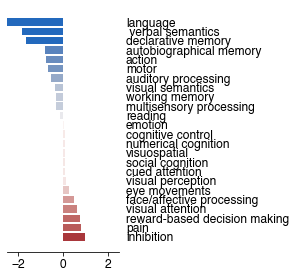

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)

    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
plt.rcParams.update({'font.size': 12})
f = plt.figure(figsize=(2,4.5))
plt.rcParams.update({'font.family':'sans-serif','font.sans-serif':'Helvetica'})
num = 12

ax = f.add_subplot(111)
ax.yaxis.tick_right()

x = np.hstack((values_sort[0:num],values_sort[-num::]))
x = x/np.max(x)
new_labels = np.hstack((labels_sort[0:num],labels_sort[-num::]))
y_pos = np.arange(len(x))
colors = sns.cm.vlag((x + 1) / 2)

plt.barh(y_pos, x, align='center', color=colors, ecolor=colors,tick_label=new_labels)
plt.xlim([-2.5,2.5])
remove_border(left=None)
plt.savefig('/Users/luke/Documents/Projects/StrokeNet/Docs/Figures/2020/'+'Decoding_barplot.svg',dpi=600)
plt.show()